Importting general libraries 

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import string
import re

Import libraries for text preprocessing

In [24]:
import contractions
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize.toktok import ToktokTokenizer

token = ToktokTokenizer()
lemma = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

punct = '!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'

Loading the dataset

In [2]:
TRAIN_DATASET_PATH = "./Dataset/train.csv"

In [3]:
full_data = pd.read_csv(TRAIN_DATASET_PATH)

In [4]:
full_data.shape

(1306122, 3)

In [5]:
full_data.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [15]:
full_data.drop('qid',axis='columns',inplace=True)

# Test Preprocessing

In [75]:
#Function for lematization

def lemitizeWords(text):
    words=token.tokenize(text)
    listLemma=[]
    for w in words:
        x=lemma.lemmatize(w, pos="v")
        listLemma.append(x)
    return ' '.join(map(str, listLemma))

In [76]:
#Function to remove stopwords

def stopWordsRemove(text):
    words = token.tokenize(text)
    filtered = [w for w in words if not w in stop_words]
    return ' '.join(map(str, filtered))

In [77]:
#Function to remove puntuations and special characters

def remove_punch(text):
    text = text.replace("\n"," ") # removing newline characters
    text = re.sub(r" +"," ",text) # Removing multiple adjacent whitespaces
    words_tok = token.tokenize(text)
    
    remove_punctuation = str.maketrans(' ', ' ', punct)
    stripped = [w.translate(remove_punctuation) for w in words_tok]
    words = [word for word in stripped if word.isalpha()]
        
    return ' '.join(map(str, words))

In [52]:
x1 = full_data['question_text'].apply(lambda x : contractions.contract(x))

In [53]:
x1 = x1.apply(lambda x : remove_punch(x))

In [54]:
x1 = x1.apply(lambda x : stopWordsRemove(x))

In [55]:
x1 = x1.apply(lambda x : lemitizeWords(x))

# Model Implementation

In [87]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import LSTM,Embedding,Dense,Dropout,BatchNormalization,Conv1D,MaxPooling1D

from sklearn.model_selection import train_test_split

In [59]:
full_data['question_text'] = x1

In [63]:
train_set,test_set = train_test_split(full_data,test_size = 0.2)

In [73]:
VOCAB_SIZE = 10000
MAX_SEQ_LEN = 75
EMBEED_DIMS = 50

token = Tokenizer(num_words=VOCAB_SIZE)
token.fit_on_texts(x1)

In [72]:
sequences_train = token.texts_to_sequences(train_set['question_text'])
sequences_test = token.texts_to_sequences(test_set['question_text'])

pad_sequences_train = pad_sequences(sequences_train,maxlen=MAX_SEQ_LEN,padding='post',truncating='post')
pad_sequences_test = pad_sequences(sequences_test,maxlen=MAX_SEQ_LEN,padding='post',truncating='post',)

In [102]:
from sklearn.utils import class_weight

weights = class_weight.compute_class_weight('balanced',
                                  np.unique(train_set['target']),
                                  train_set['target'])

print(weights)

[0.53295246 8.086687  ]


In [79]:
GLOVE_PATH = "./glove.6B/glove.6B.50d.txt"

embeddings_index = dict()

with open(GLOVE_PATH,'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeff = np.asarray(values[1:],dtype='float32')
        embeddings_index[word] = coeff

In [85]:
embeddings_matrix = np.zeros((VOCAB_SIZE,EMBEED_DIMS))
for word, index in token.word_index.items():
    if index > VOCAB_SIZE - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embeddings_matrix[index] = embedding_vector

In [103]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [172]:
checkpoint_filepath = "./check_points/"
if os.path.isdir(checkpoint_filepath) is not True:
    print("Folder for Checkpoints doen't exists")
    os.mkdir(checkpoint_filepath)
    
if os.path.isdir(checkpoint_filepath) is True:
    print("Folder of Checkpoints exists")
    

checkpoint = ModelCheckpoint(checkpoint_filepath + '{epoch:03d}-{val_accuracy:.4f}.hdf5',
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

Folder of Checkpoints exists


In [179]:
model = Sequential()

In [174]:
model.add(Embedding(VOCAB_SIZE,EMBEED_DIMS,input_length=MAX_SEQ_LEN,weights = [embeddings_matrix],trainable = False))

model.add(Conv1D(64,5,activation='relu'))
model.add(MaxPooling1D(pool_size=4))

model.add(LSTM(100,return_sequences=True))
model.add(LSTM(50))

model.add(Dense(512,activation = 'relu'))

model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(256,activation='relu'))

model.add(Dense(2,activation = 'sigmoid'))

In [175]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [176]:
EPOCHS = 500

In [109]:
os.mkdir("./Saved Model/")
model_json = model.to_json()
with open("./Saved Model/Quora spam model.json",'w') as file:
    file.write(model_json)


In [110]:
model.save_weights('./Saved Model/Quora spam model weights.h5')

In [112]:
hist_df = pd.DataFrame(model.history.history)
hist_df.to_csv("./model_history.csv")

In [113]:
model.evaluate(pad_sequences_test,test_set['target'])

261225/261225 [==============================] - 42s 162us/sample - loss: 0.1400 - accuracy: 0.9380


[0.14002004132571774, 0.9379692]

In [115]:
pred = model.predict_classes(pad_sequences_test)

In [119]:
np.unique(pred)

array([0])

In [121]:
np.unique(test_set['target'])
np.count_nonzero(test_set['target']),np.count_nonzero(pred)

(16204, 0)

##### Model has become a dumb model so we'll use bidirectional LSTM and increase the sequence length

In [168]:
NEW_SEQ_LEN = 200

pad_sequences_train = pad_sequences(sequences_train,maxlen=NEW_SEQ_LEN,padding='post',truncating='post')
pad_sequences_test = pad_sequences(sequences_test,maxlen=NEW_SEQ_LEN,padding='post',truncating='post')

creating new Checkpoints folder

In [180]:
checkpoint_filepath = "./check_points_seq_len_200/"
if os.path.isdir(checkpoint_filepath) is not True:
    print("Folder for Checkpoints doen't exists")
    os.mkdir(checkpoint_filepath)
    
if os.path.isdir(checkpoint_filepath) is True:
    print("Folder of Checkpoints exists")
    
checkpoint_seq_200 = ModelCheckpoint(checkpoint_filepath + '{epoch:03d}-{val_accuracy:.4f}.hdf5',
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

Folder of Checkpoints exists


In [170]:
from tensorflow.keras.layers import SpatialDropout1D,Bidirectional

In [191]:
model_200 = Sequential()

In [192]:
model_200.add(Embedding(VOCAB_SIZE,EMBEED_DIMS,input_length=NEW_SEQ_LEN,weights = [embeddings_matrix],trainable = False))

# model.add(SpatialDropout1D(0.2))

model_200.add(Bidirectional(LSTM(64,return_sequences=True,activation='relu')))
model_200.add(Bidirectional(LSTM(64,return_sequences=False,activation='relu')))

model_200.add(Dense(2,activation='softmax'))

model_200.compile(optimizer='rmsprop',loss='sparse_categorical_crossentropy',metrics=['accuracy'])



In [193]:
model_200.fit(pad_sequences_train,train_set['target'],
              validation_split=0.2,class_weight=weights,
              callbacks=[checkpoint_seq_200],epochs=EPOCHS)

Train on 835917 samples, validate on 208980 samples
Epoch 1/500
835904/835917 [============================>.] - ETA: 0s - loss: nan - accuracy: 0.9385
Epoch 00001: val_accuracy improved from -inf to 0.93746, saving model to ./check_points_seq_len_200/001-0.9375.hdf5
835917/835917 [==============================] - 6393s 8ms/sample - loss: nan - accuracy: 0.9385 - val_loss: nan - val_accuracy: 0.9375
Epoch 2/500
 30816/835917 [>.............................] - ETA: 1:31:14 - loss: nan - accuracy: 0.9382

KeyError: 'val_accuracy'

In [139]:
model_200.evaluate(pad_sequences_test,test_set['target'])

261225/261225 [==============================] - 298s 1ms/sample - loss: nan - accuracy: 0.9380


[nan, 0.9379692]

#### Making Predictions

Model has automatically saved weights for the 1st epoch as instructed by checkpoint callback. So loading those weights for predictions

In [198]:
model_200.load_weights('./check_points_seq_len_200/001-0.9375.hdf5')

In [199]:
pred1 = model_200.predict(pad_sequences_test)

In [201]:
pred1

array([[9.7661728e-01, 2.3382729e-02],
       [9.8358065e-01, 1.6419414e-02],
       [9.9496907e-01, 5.0309743e-03],
       ...,
       [3.7028876e-01, 6.2971115e-01],
       [9.9779761e-01, 2.2024477e-03],
       [9.9978107e-01, 2.1895779e-04]], dtype=float32)

In [202]:
preds = []
for i in pred1:
    preds.append(i.argmax())
preds = np.asarray(preds)

In [203]:
np.unique(preds)

array([0, 1])

In [204]:
np.count_nonzero(preds)

11349

In [158]:
test_set['target'].value_counts()

0    245021
1     16204
Name: target, dtype: int64

In [212]:
p = model_200.predict_classes(pad_sequences_test)

In [214]:
p

array([0, 0, 0, ..., 1, 0, 0])

In [215]:
preds

array([0, 0, 0, ..., 1, 0, 0])

#### Lets check the performance of the Model

In [206]:
from sklearn import metrics

In [223]:
print("Accuracy of the model: {}".format(metrics.accuracy_score(test_set['target'],preds)))
print("AUC-ROC Score for the model : {}".format(metrics.roc_auc_score(test_set['target'],preds)))
print("F1-Score of the model : {}".format(metrics.f1_score(test_set['target'],preds)))

Accuracy of the model: 0.950521581012537
AUC-ROC Score for the model : 0.7174510279382791
F1-Score of the model : 0.5309040757812217


#### Plotting Confussion Matrix

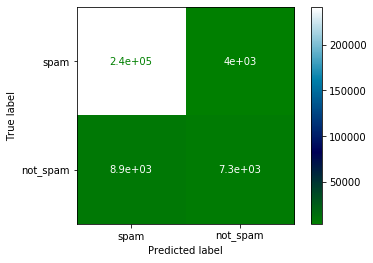

In [229]:
cf = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(test_set['target'],preds),display_labels=('spam','not_spam'))
cf.plot(cmap = 'ocean')

#### Summary  report for the Model

In [163]:
print(metrics.classification_report(test_set['target'],preds))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97    245021
           1       0.64      0.45      0.53     16204

    accuracy                           0.95    261225
   macro avg       0.80      0.72      0.75    261225
weighted avg       0.94      0.95      0.95    261225

